In [31]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

df = pd.read_csv('Groceries_dataset.csv')

print(df.head())
print(df.info())

print(f"Unique Items: {df['itemDescription'].nunique()}")
print(f"Unique Members: {df['Member_number'].nunique()}")
print(f"Unique Dates: {df['Date'].nunique()}")

   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB
None
Unique Items: 167
Unique Members: 3898
Unique Dates: 728


In [32]:
transactions = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index()

vertical_data = defaultdict(set)
for idx, row in transactions.iterrows():
    for item in set(row['itemDescription']):
        vertical_data[item].add(idx)

print(f"Number of items in vertical format: {len(vertical_data)}\n")

items_list = sorted(list(vertical_data.keys()))
for item in items_list[:10]:
    tids = sorted(list(vertical_data[item]))
    display_tids = tids[:10]
    print(f"Item: {item}")
    print(f"TID Set (first 10): {display_tids} (Total count: {len(tids)})\n")

Number of items in vertical format: 167

Item: Instant food products
TID Set (first 10): [140, 161, 221, 327, 1089, 1204, 1215, 1300, 1725, 2728] (Total count: 60)

Item: UHT-milk
TID Set (first 10): [38, 65, 97, 178, 214, 268, 401, 411, 438, 463] (Total count: 320)

Item: abrasive cleaner
TID Set (first 10): [856, 1050, 5284, 6451, 6640, 7316, 7976, 8626, 8816, 8877] (Total count: 22)

Item: artif. sweetener
TID Set (first 10): [280, 977, 1467, 3279, 3575, 3841, 5118, 5608, 5729, 5917] (Total count: 29)

Item: baby cosmetics
TID Set (first 10): [2014, 4003, 14095] (Total count: 3)

Item: bags
TID Set (first 10): [1636, 5271, 6296, 11649] (Total count: 4)

Item: baking powder
TID Set (first 10): [82, 111, 288, 318, 397, 407, 472, 547, 639, 667] (Total count: 121)

Item: bathroom cleaner
TID Set (first 10): [296, 3658, 4281, 4712, 4956, 5881, 5892, 7146, 7187, 8123] (Total count: 17)

Item: beef
TID Set (first 10): [8, 63, 71, 86, 153, 187, 223, 241, 293, 303] (Total count: 508)

Item: 

Running Eclat with Min Support: 22 transactions


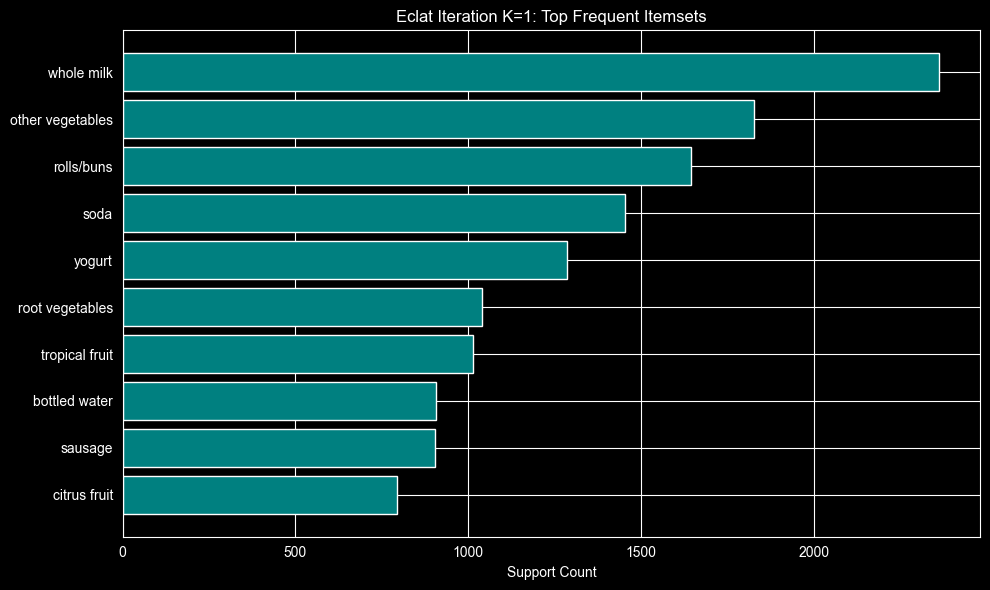

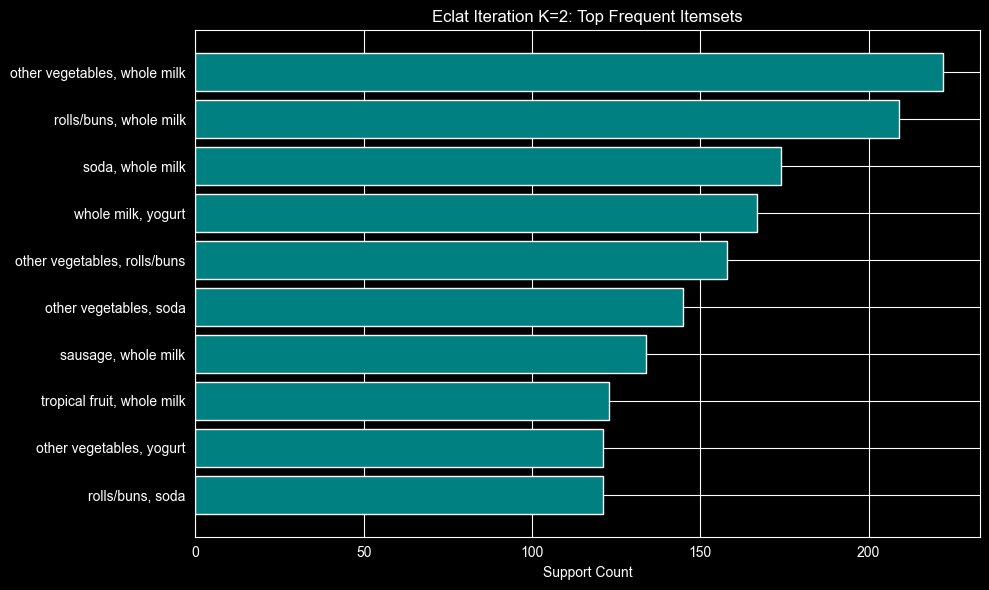

             Itemset  Size  Support
1         whole milk     1     2363
18  other vegetables     1     1827
13        rolls/buns     1     1646
9               soda     1     1453
0             yogurt     1     1285


In [33]:
def eclat_iterative(vertical_data, min_support):
    frequent_itemsets_by_k = {}

    current_level_items = []
    frequent_itemsets_by_k[1] = {}

    for item, tids in vertical_data.items():
        if len(tids) >= min_support:
            itemset = (item,)
            frequent_itemsets_by_k[1][itemset] = len(tids)
            current_level_items.append((itemset, tids))

    current_level_items.sort(key=lambda x: x[0])
    k = 1
    while True:
        k += 1
        next_level_items = []

        num_items = len(current_level_items)
        frequent_itemsets_by_k[k] = {}

        for i in range(num_items):
            itemset_a, tids_a = current_level_items[i]

            for j in range(i + 1, num_items):
                itemset_b, tids_b = current_level_items[j]

                if itemset_a[:-1] == itemset_b[:-1]:
                    new_itemset = itemset_a + (itemset_b[-1],)

                    new_tids = tids_a & tids_b

                    if len(new_tids) >= min_support:
                        frequent_itemsets_by_k[k][new_itemset] = len(new_tids)
                        next_level_items.append((new_itemset, new_tids))

        if not next_level_items:
            break

        current_level_items = next_level_items

    return frequent_itemsets_by_k

total_transactions = 14963
min_support_count = total_transactions * 0.0015
print(f"Running Eclat with Min Support: {int(min_support_count)} transactions")

results = eclat_iterative(vertical_data, min_support_count)

for k, itemsets in results.items():
    if not itemsets: continue

    top_items = sorted(itemsets.items(), key=lambda x: x[1], reverse=True)[:10]

    labels = [", ".join(item) for item, _ in top_items]
    counts = [count for _, count in top_items]

    plt.figure(figsize=(10, 6))
    plt.barh(labels, counts, color='teal')
    plt.xlabel('Support Count')
    plt.title(f'Eclat Iteration K={k}: Top Frequent Itemsets')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

all_results = []
for k, itemsets in results.items():
    for itemset, support in itemsets.items():
        all_results.append({
            'Itemset': ", ".join(itemset),
            'Size': k,
            'Support': support
        })

final_df = pd.DataFrame(all_results).sort_values(by='Support', ascending=False)
print(final_df.head())